# Exploratory Data Analysis - Crime Data Los Angeles

This notebook is used to explore the questions for the Data Scientist Exercise in July 2020.

- How many crimes were reported over the past 5 years?
- List the top five reported crimes for each year for the past 5 years.
- What are the most common MO codes? Have these changed over the past 5 years?
- How else has reported crime changed over time in the City?
- Based on your analysis, please share any changes to services, programs, or policies that the City should consider.

##  Load libraries

In [1]:
# Import libraries
import os, sys, subprocess
import json
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [2]:
# load project config
terminal_call = ! git rev-parse --show-toplevel
repo_path=terminal_call[0]
project_config_path = os.path.join(repo_path,'project_config.json')

with open(project_config_path,'r') as fp: 
    project_config = json.load(fp)

In [3]:
# import custom module to look at trends
module_path = os.path.join(repo_path,project_config['project_module_relative_path'])
sys.path.append(module_path)

import trends
from trends import get_top_trends as gt
from trends import convert
from trends.convert import crime_dict, mocode_dict # load in crime name dictionary
from importlib import reload # for updating scripts

# Load in data

In [4]:
# load in data that was collected
df = pickle.load(open("../data/crime_data.pkl", "rb"))

In [5]:
# Explore summary info
def eda(df):
    nulls = pd.DataFrame(df.isnull().sum()).T # Check for nulls
    datatypes = pd.DataFrame(df.dtypes).T # Check datatypes
    summary = pd.concat([nulls, datatypes], keys = ["nulls", "datatypes"]) # Create pandas dataframe, because I think it's easier to read
    return summary

In [6]:
eda(df)

,,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,year,mocodes_1,mocodes_2,mocodes_3
nulls,0,0,0,0,0,0,0,0,0,0,0,240361,0,208478,208527,55,228,1464999,1465000,3,0,11,2063105,2206364,2209991,0,1837686,0,0,0,0,240361,240361
datatypes,0,int64,datetime64[ns],datetime64[ns],int64,int64,object,int64,int64,int64,object,object,int64,object,object,float64,object,float64,object,object,object,float64,float64,float64,float64,object,object,float64,float64,int64,int64,object,object


## How many crimes were reported over the past 5 years?

In [5]:
# Check how many crimes were reported over the past 5 years
# Calculate current date and offset by 5 years
total_reported = (df["date_rptd"] > (pd.datetime.now()- pd.DateOffset(years=5))).sum()
print(f'A: {total_reported} crimes were reported in the past 5 years.')

A: 1116665 crimes were reported in the past 5 years.


## List the top five reported crimes for each year for the past 5 years.

### Subset data for the last 5 years

In [6]:
# Select the last 5 years as a dataframe
df_5 = df[df["date_rptd"] > (pd.datetime.now()- pd.DateOffset(years=5))]

In [7]:
# Find the top 5 reported crimes for each year
# Crime is listed in the data under 'crm_cd'
# Custom function 'top_trends' groups by column and selects the top 'n' 
top_crimes = gt.top_trends(df_5, column='year', variable='crm_cd', n=5)

In [8]:
# Add in the name of the crimes to dataframe
top_crimes["crm_name"] = convert.get_names(top_crimes, "crm_cd", crime_dict)

In [9]:
# create a rank column
top_crimes["rank"] = top_crimes.groupby('year')["count"].rank(ascending=False)

In [10]:
last_points = pd.DataFrame(top_crimes.groupby("crm_cd").tail(1)).reset_index()

In [11]:
colors = ["green"]*top_crimes["crm_cd"].unique().shape[0]

Text(0.5, 1.0, 'Top 5 Crimes Per Year')

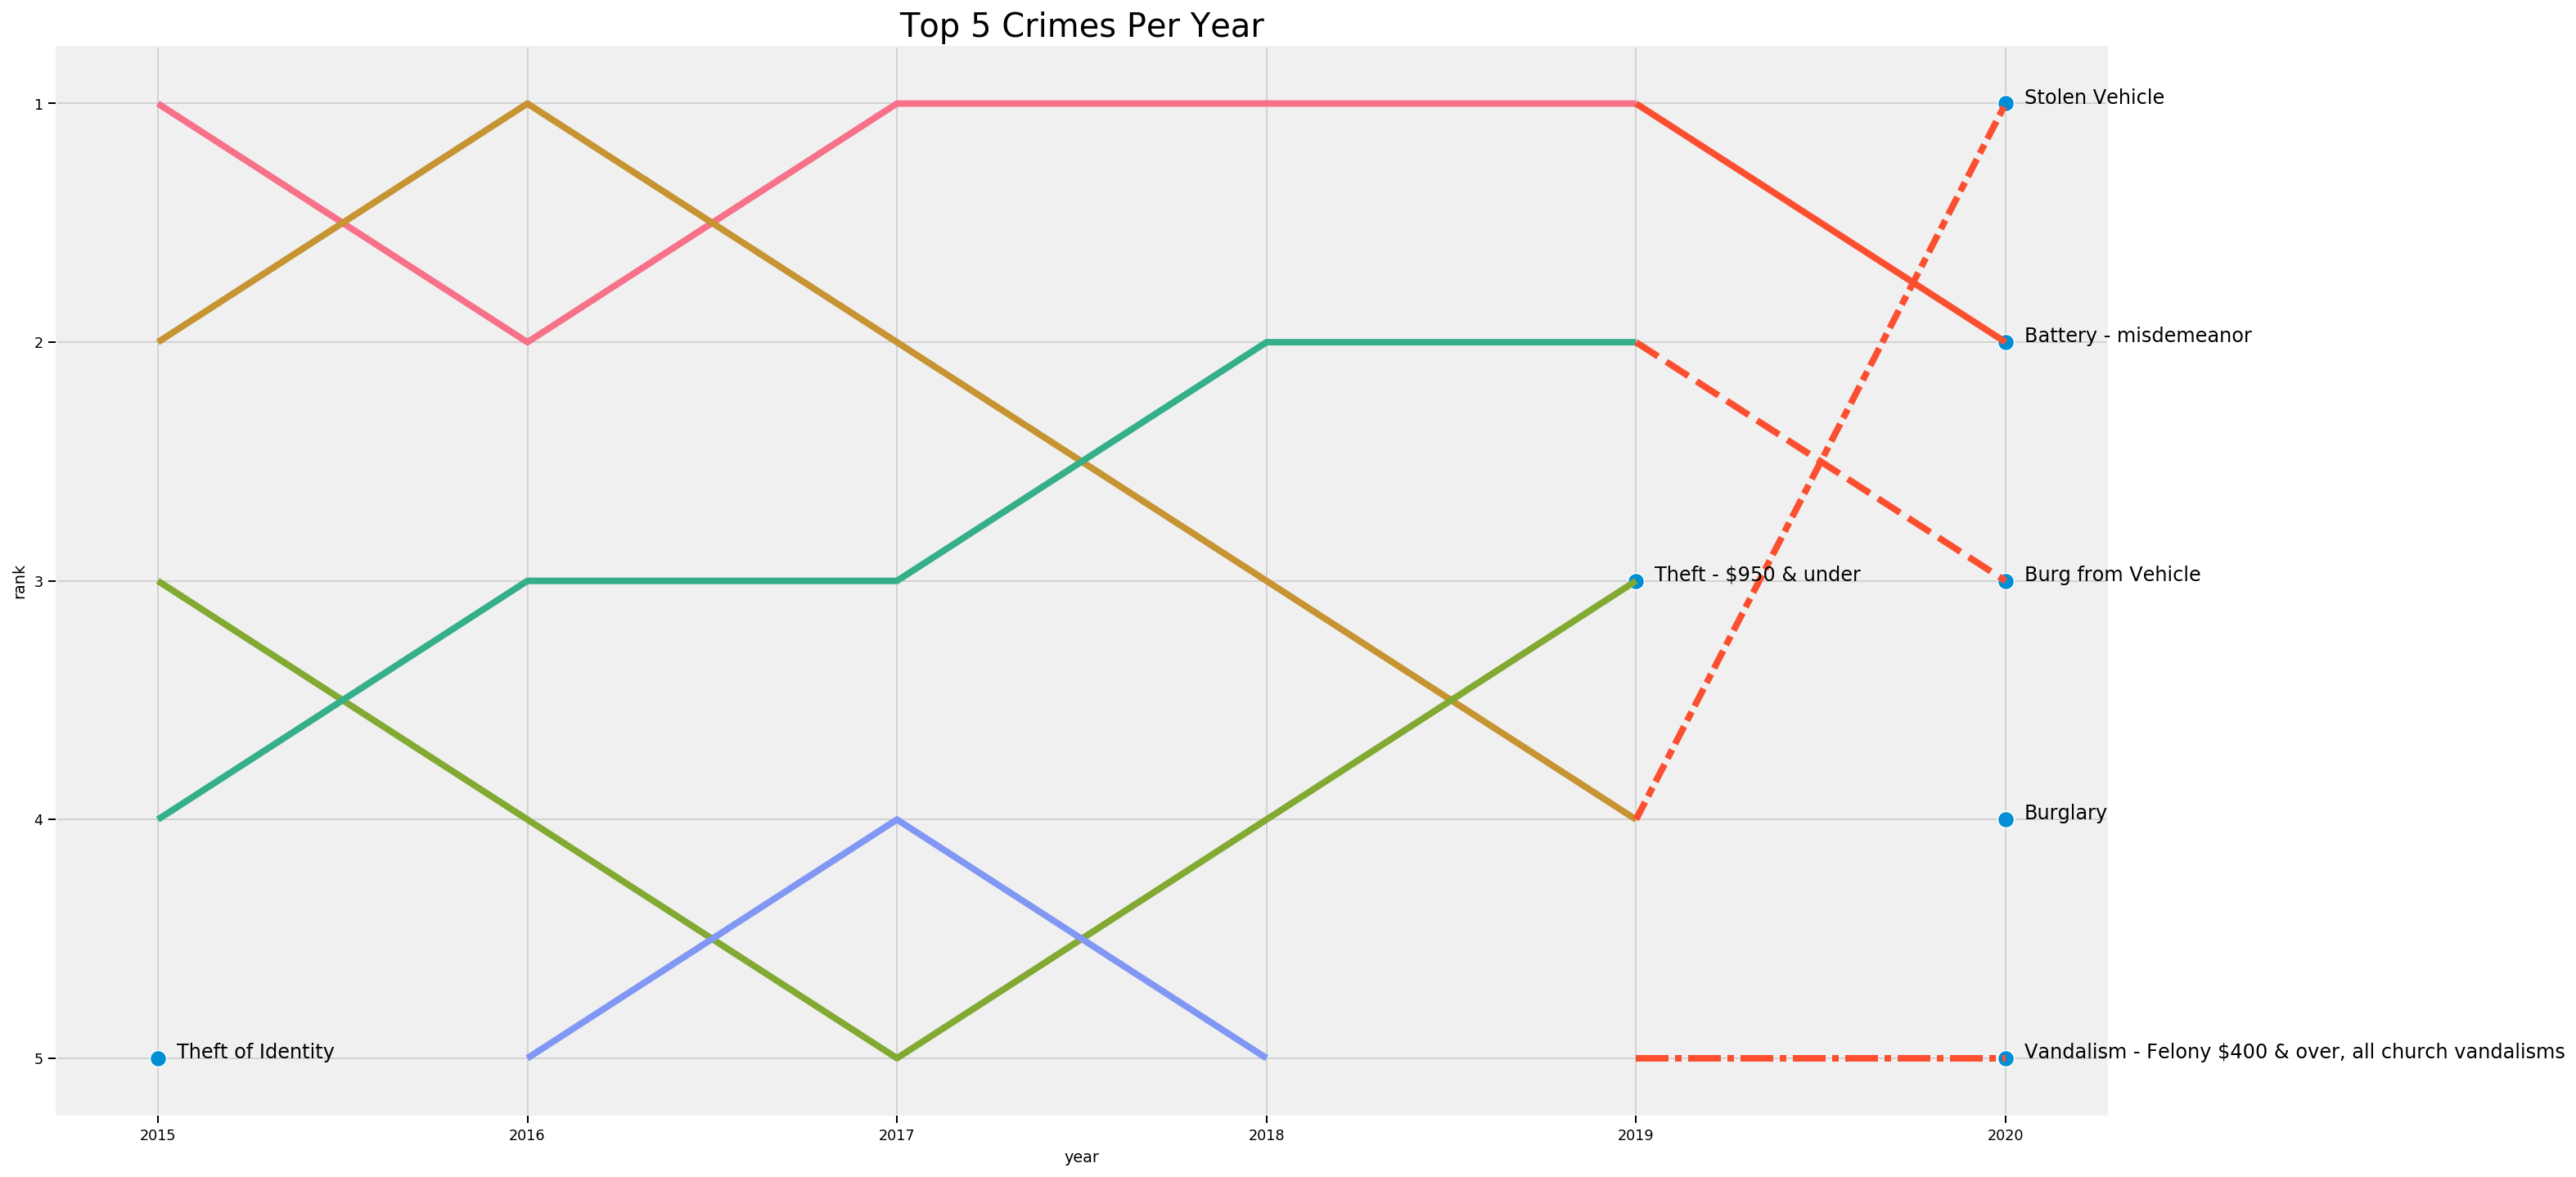

In [12]:
plt.figure(figsize=(20,12))

paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc) 


ax = sns.lineplot(x="year", y="rank", hue="crm_name",markers = False,
                  data=top_crimes[top_crimes["year"]<=2019], legend = False, palette = sns.color_palette("husl", 7))
ax = sns.lineplot(x="year", y="rank", style="crm_name",markers = False,
                  data=top_crimes[top_crimes["year"]>=2019], legend = False, dashes = True)

ax = sns.scatterplot(x="year", y="rank", data=last_points, 
                     legend=False)


for i in range(0,last_points.shape[0]):
    ax.text(last_points["year"][i]+0.05, last_points["rank"][i],
           last_points["crm_name"][i], horizontalalignment='left', size =12)
    
plt.ylim(reversed(plt.ylim()))
plt.yticks([5,4,3,2,1]);
plt.title("Top 5 Crimes Per Year", fontsize=20)

## What are the most common MO codes? Have these changed over the past 5 years?

From the summary info above, I see there are 240361 rows of missing MO codes in the original dataframe. I will remove the NA for this question.

In [40]:
# Select the last 5 years as a dataframe
df_5 = df_5[df_5["mocodes"].notnull()]

In [41]:
# Find the top 10 most common MO codes across all the years (2010-2020)
df_5["mocodes"].value_counts(ascending = False).head(10)

0344         93804
0329         44382
1501         18458
0325         12730
0416         12308
0329 1300    8299 
1822         8233 
0344 1300    6088 
0344 1606    5894 
0329 1307    4803 
Name: mocodes, dtype: int64

In [86]:
# Find the top 10 MO codes for each year
# MO code is listed in the data under 'mocodes'
# Custom function 'top_trends' groups by column and selects the top 'n' 
top_mo = gt.top_trends(df_5, column='year', variable='mocodes_1', n=10)

In [87]:
# Add in the name of the MO codes to dataframe
top_mo["mo_name"] = convert.get_names(top_mo, "mocodes_1", mocode_dict)

In [88]:
# create a rank column
top_mo["rank"] = top_mo.groupby('year')["count"].rank(ascending=False)

In [89]:
top_mo.head()

,year,mocodes_1,count,mo_name,rank
0,2015,344,24775,Removes vict property,1.0
1,2015,329,9250,Vandalized,2.0
2,2015,2000,5584,Domestic violence,3.0
3,2015,416,5120,Hit-Hit w/ weapon,4.0
4,2015,325,2809,Took merchandise,5.0


(10.45, 0.55)

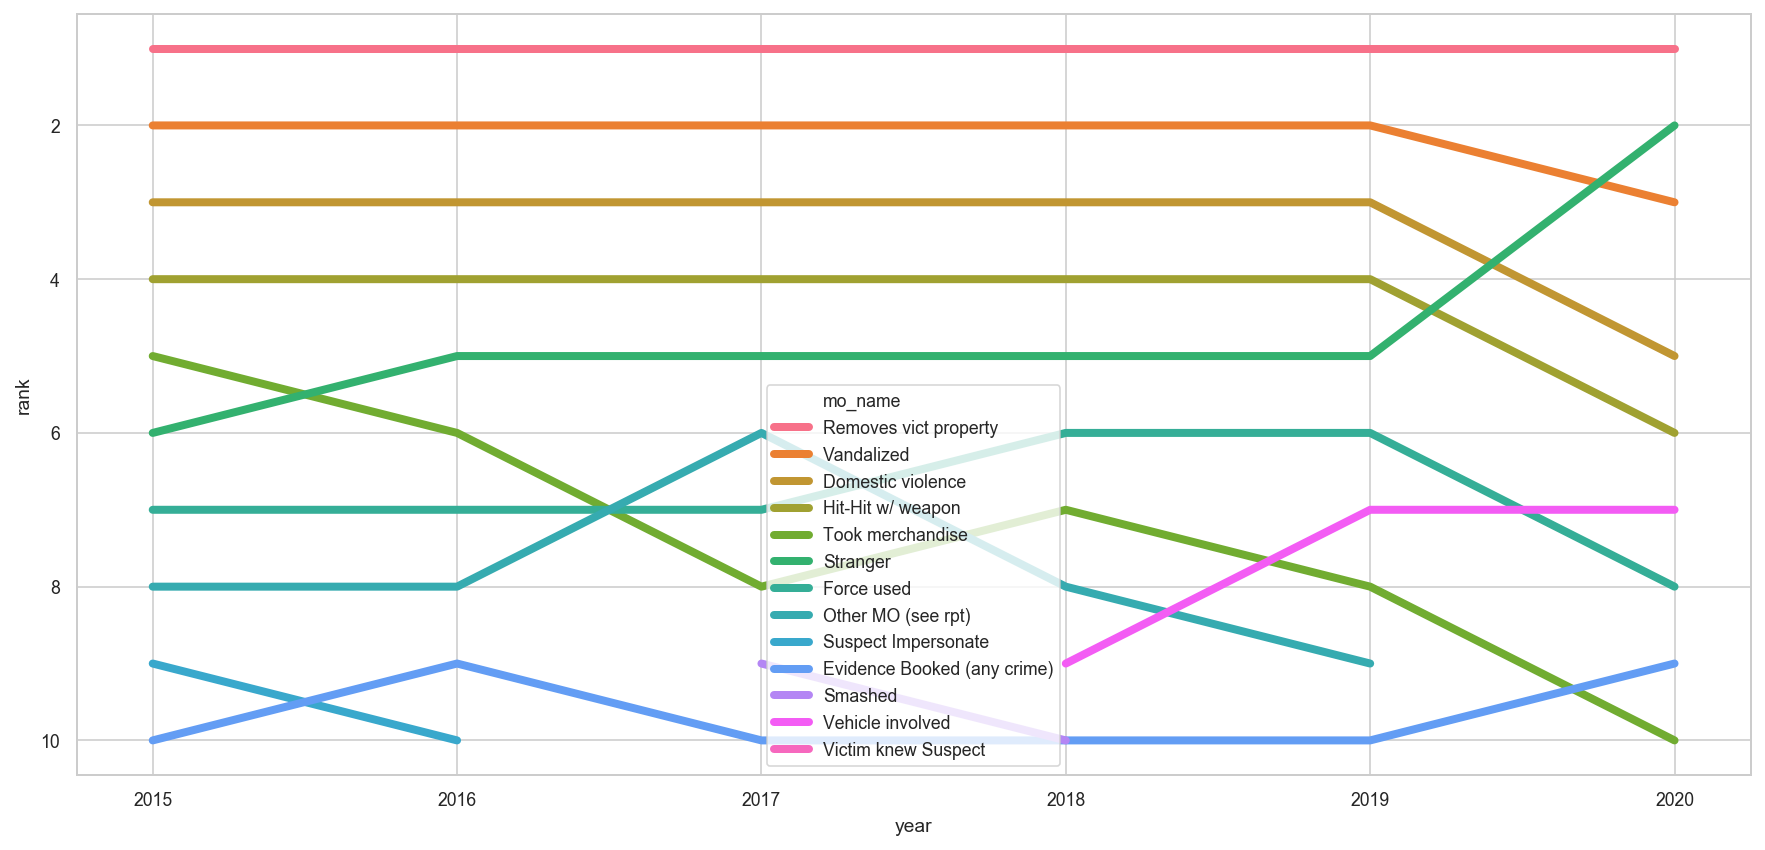

In [90]:
plt.figure(figsize=(15, 7))

ax = sns.lineplot(x="year", y="rank", hue="mo_name", markers = True,
                  data=top_mo)

plt.ylim(reversed(plt.ylim()))

In [91]:
last_points_mo = pd.DataFrame(top_mo.groupby("mocodes_1").tail(1)).reset_index()

In [92]:
last_points_mo

,index,year,mocodes_1,count,mo_name,rank
0,421,2016,100,3660,Suspect Impersonate,10.0
1,1404,2018,1609,4044,Smashed,10.0
2,1925,2019,1501,4017,Other MO (see rpt),9.0
3,2434,2020,344,15521,Removes vict property,1.0
4,2435,2020,1822,8101,Stranger,2.0
5,2436,2020,329,7932,Vandalized,3.0
6,2437,2020,913,4498,Victim knew Suspect,4.0
7,2438,2020,2000,4184,Domestic violence,5.0
8,2439,2020,416,3133,Hit-Hit w/ weapon,6.0
9,2440,2020,1300,3091,Vehicle involved,7.0


In [93]:
palette = sns.color_palette("husl", top_mo["mo_name"].unique().shape[0])

Text(0.5, 1.0, 'Top 10 MO Codes Per Year')

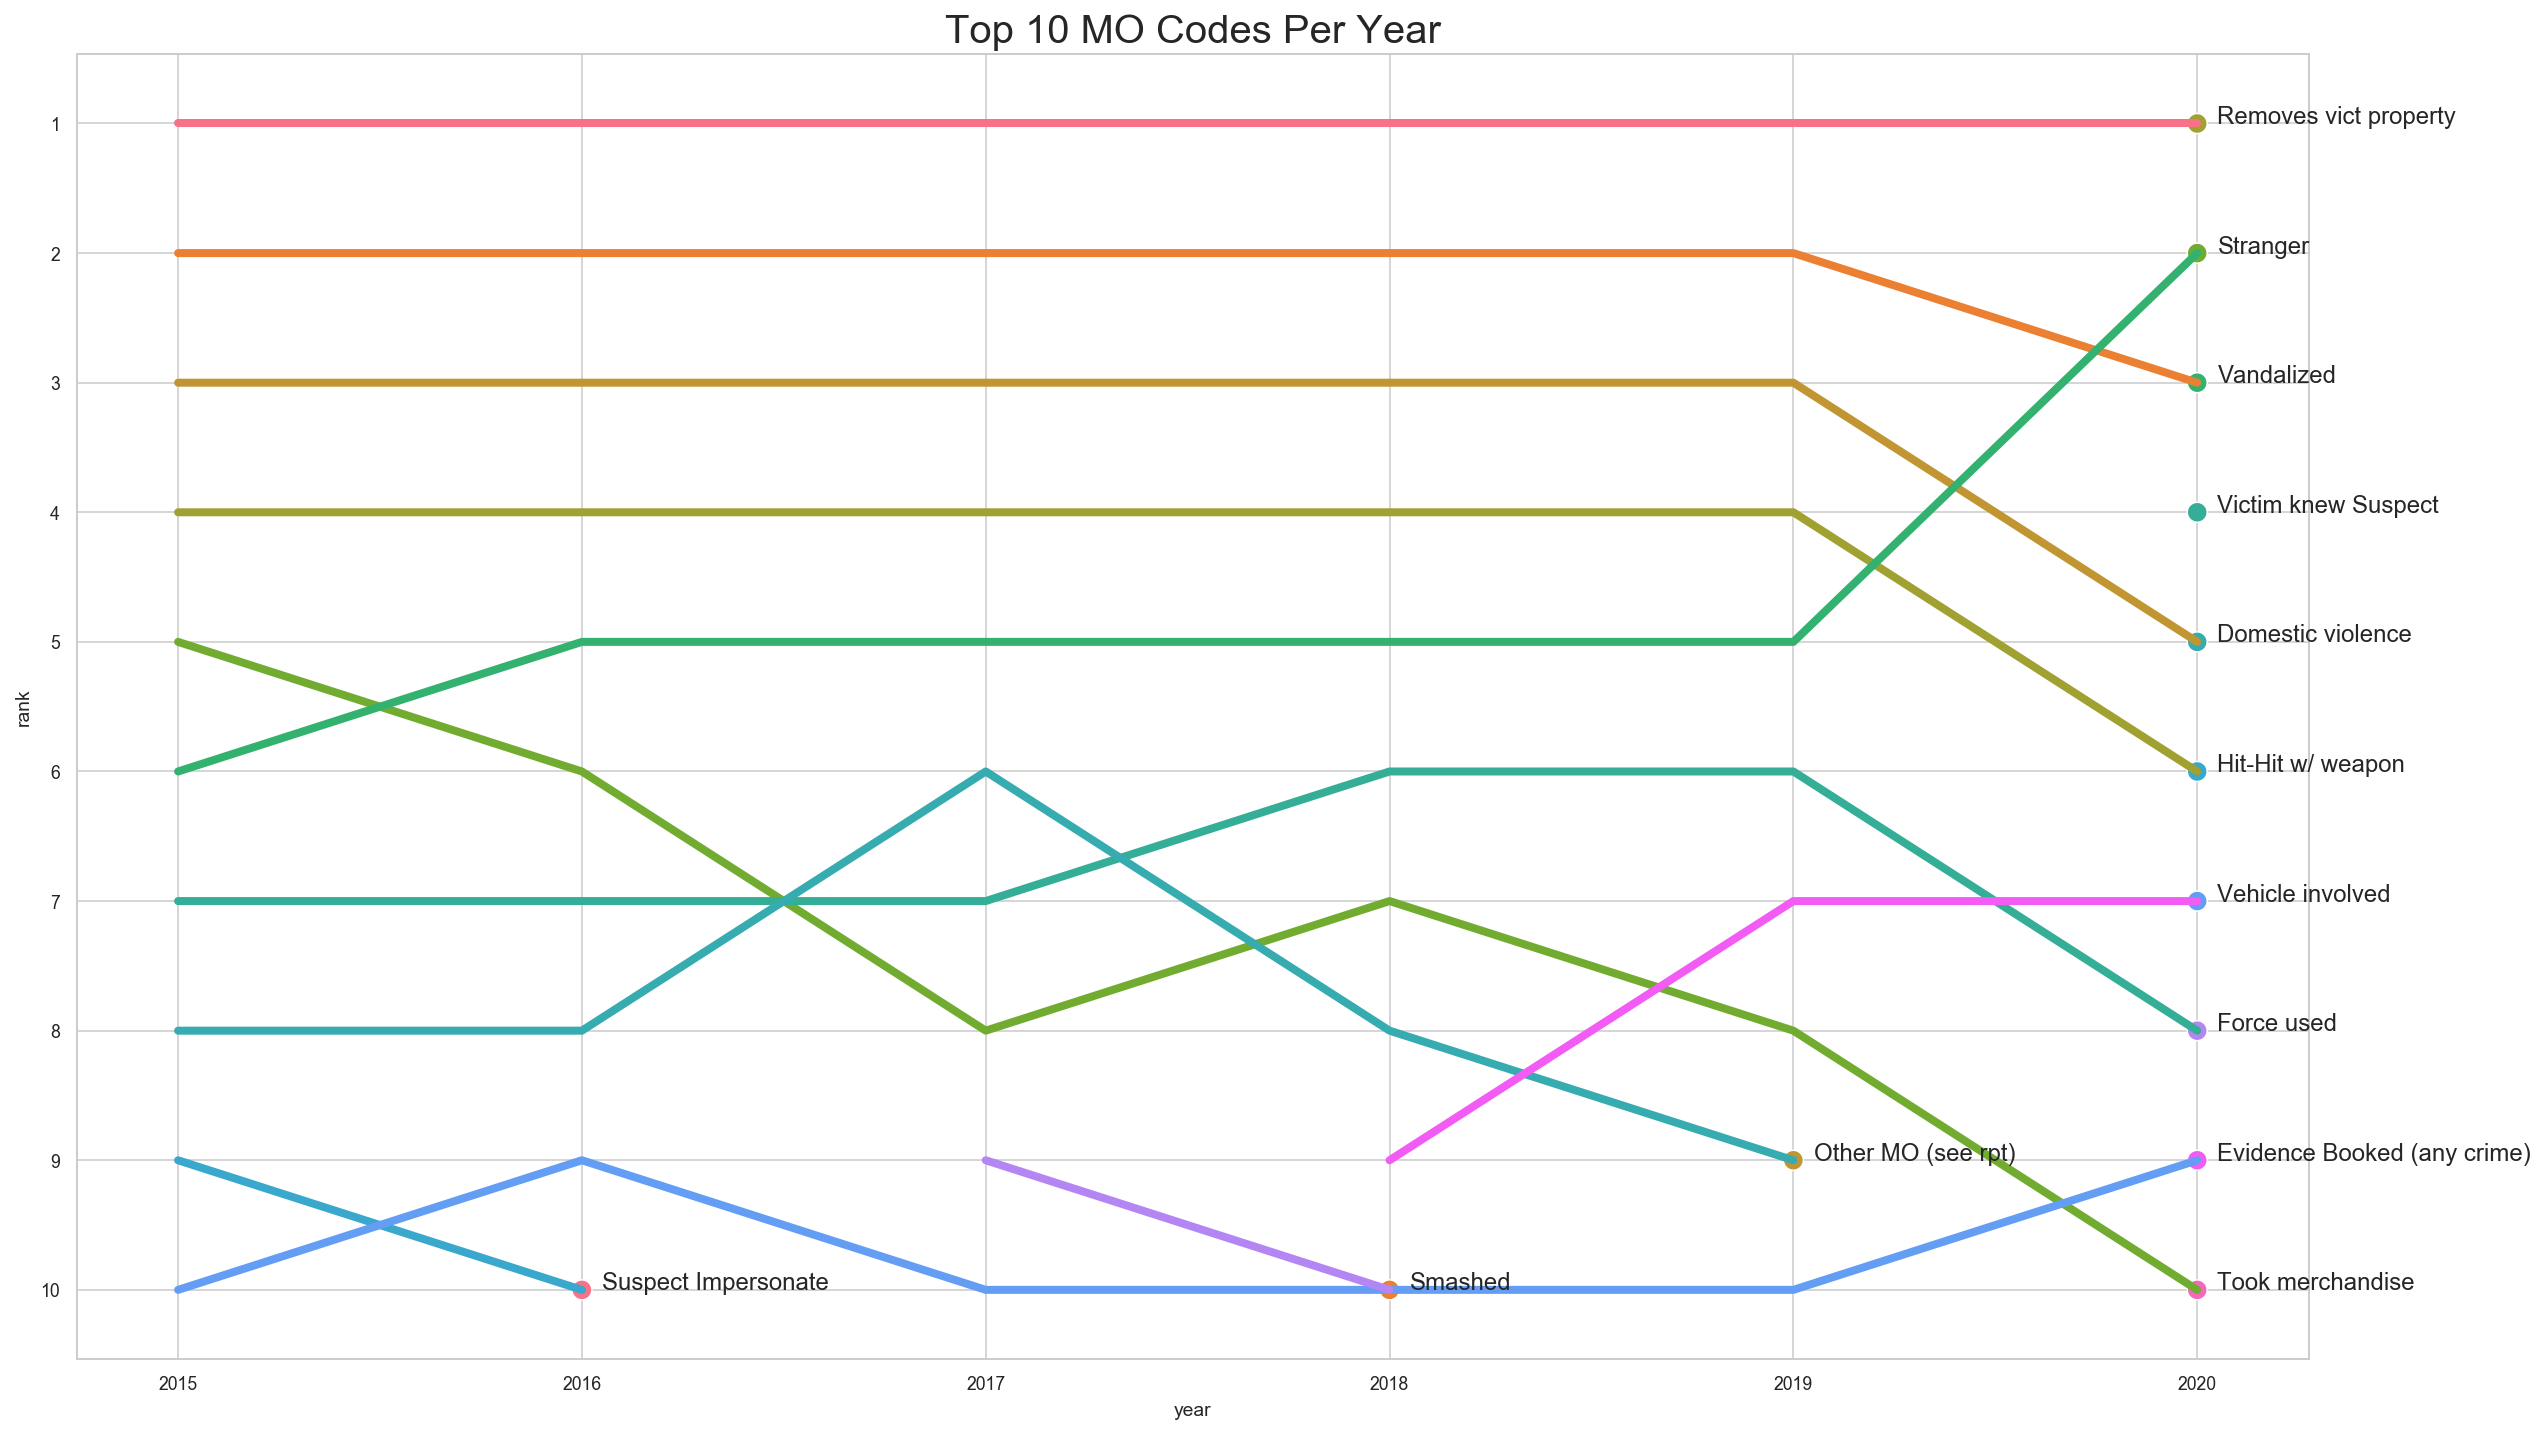

In [94]:
plt.figure(figsize=(20,12))

paper_rc = {'lines.linewidth': 4, 'lines.markersize': 10}                  
sns.set_context("paper", rc = paper_rc) 


ax = sns.lineplot(x="year", y="rank", hue="mo_name",markers = False,
                  data=top_mo, legend = False, palette = palette)
#ax = sns.lineplot(x="year", y="rank", style="mo_name",markers = False,
    #             data=top_mo[top_mo["year"]>=2019], legend = False, dashes = True)


ax = sns.scatterplot(x="year", y="rank", data=last_points_mo, 
        legend=False, hue="mo_name", palette = palette)


for i in range(0,last_points_mo.shape[0]):
     ax.text(last_points_mo["year"][i]+0.05, last_points_mo["rank"][i],
             last_points_mo["mo_name"][i], horizontalalignment='left', size =12)
    
plt.ylim(reversed(plt.ylim()))
plt.yticks([10,9,8,7,6,5,4,3,2,1]);
plt.title("Top 10 MO Codes Per Year", fontsize=20)